In [4]:
# Enable auto-reload of modified python files.
%load_ext autoreload
%autoreload 2

# imports
import warnings
import settings
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# get average rating score across 7 raters
df = pd.read_csv(settings.DATA_PATH + '/boundaries.csv')
df1 = df.loc[df['score'] != 'na']
df1['score'] = df1['score'].astype(float)
result = df1.groupby(['condition','image','drawing']).mean().reset_index()

participants = []
for i, row in result.iterrows():
    participants.append(row.drawing.split('_')[0].replace('control', ''))
result['participant'] = participants  
result['score'] =  -1 * result['score'] 
result['contraction'] = np.where(result['score']> 0, 1, 0)
result['extension'] = np.where(result['score']< 0, 1, 0)
result['same'] = np.where(result['score']== 0, 1, 0)

# chi-square results for percent transformation by condition
grouped = result.groupby(['condition', 'image']).mean().reset_index()
counts = result.groupby(['condition', 'image']).sum().reset_index() 

print('memorize contraction:', grouped[grouped['condition']=='memorize'].mean()['contraction'])
print('memorize extension:', grouped[grouped['condition']=='memorize'].mean()['extension'])
chi2, p, dof, expected = stats.chi2_contingency(np.array([[result[result['condition']=='memorize']['contraction'].sum(), len(result[result['condition']=='memorize'])], 
                                                          [result[result['condition']=='memorize']['extension'].sum(), len(result[result['condition']=='memorize'])]]))


print('chi:', chi2, 'p:', p, 'df:', dof)

print('search contraction:', grouped[grouped['condition']=='search'].mean()['contraction'])
print('search extension:', grouped[grouped['condition']=='search'].mean()['extension'])
chi2, p, dof, expected = stats.chi2_contingency(np.array([[result[result['condition']=='search']['contraction'].sum(), len(result[result['condition']=='search'])], 
                                                          [result[result['condition']=='search']['extension'].sum(), len(result[result['condition']=='search'])]]))


print('chi:', chi2, 'p:', p, 'df:', dof)
print(stats.ranksums(grouped [grouped["condition"]=='memorize']['contraction'],grouped [grouped["condition"]=='search']['contraction']))

memorize contraction: 0.4466721840251252
memorize extension: 0.47948943213649103
chi: 0.0397570816453315 p: 0.8419562905615328 df: 1
search contraction: 0.6228863819100705
search extension: 0.30730664832551197
chi: 27.9966880852557 p: 1.2152325772275837e-07 df: 1
RanksumsResult(statistic=-2.3227717961961525, pvalue=0.020191414969204242)


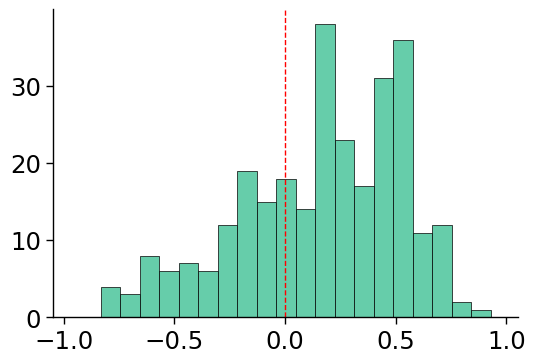

In [6]:
# plot search
sns.set_context("paper",  font_scale=2)
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(result[result['condition']=='search']['score'], color='mediumaquamarine', edgecolor='black',linewidth=.5, bins=20)
ax.axvline(x = 0, color = 'red', linestyle = '--', linewidth=1)
ax.set_xlim([-1.05, 1.05])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(settings.RESULTS_PATH + '/figure3/3a.svg', dpi=1000)  

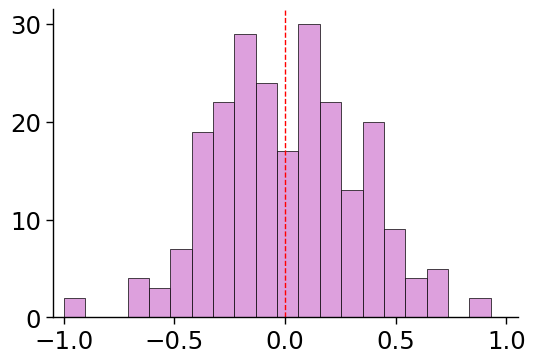

In [7]:
# plot memorize
sns.set_context("paper",  font_scale=2)

fig, ax = plt.subplots(figsize=(6,4))

ax.hist(result[result['condition']=='memorize']['score'], color='plum', edgecolor='black',linewidth=.5, bins=20)
ax.axvline(x = 0, color = 'red', linestyle = '--', linewidth=1)
ax.set_xlim([-1.05, 1.05])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(settings.RESULTS_PATH + '/figure3/3c.svg', dpi=1000)  

In [8]:
# split-half across 1,000 iterations with spearman-brown correction formula
conditions = ["search", "memorize"]
for c in conditions:
    Cdf = df[df['condition']== c]
    lists = []
    ids=[]
    for i in Cdf.drawing.unique():
        currdf= Cdf[Cdf['drawing']==i]
        if len(currdf)== 7:
            lists.append(currdf['response'].tolist())
            ids.append(currdf['drawing'].tolist())
        else:
            print(i)
    x = np.concatenate(lists)
    x = x.reshape(int(len(x)/7), 7)
    x = x.astype('float')
    y = np.concatenate(ids)
    y = y.reshape(int(len(y)/7),7)
    x[x==5] = -1
    x[x==4] = -.5
    x[x==3] = 0
    x[x==2] = .5
    x[x==1] = 1
    x[x==6] = np.nan
    dfs = []
    allR = []
    chanceRs = []
    iterations = 1000
    for m in range(0, iterations):
        df1 = pd.DataFrame()
        x1, y1 = unison_shuffled_copies(x.T, y.T) 
        left, right = np.array_split(x1, 2)
        left = np.nanmean(left, axis=0)
        left[np.isnan(left)] = 0
        right = np.nanmean(right, axis=0)
        right[np.isnan(right)] = 0
        df1["left"]= left
        df1['right'] = right
        df1['scene'] = y1[0,:]
        
        # calculate the mean of each half 
        R = stats.spearmanr(left, right)[0]
        allR.append((2.0 * R) / (1.0 + R))
        np.random.shuffle(right)
        np.random.shuffle(left)
        df1["chance"] = right
        dfs.append(df1)
        chanceR = stats.spearmanr(left,right)[0]
        chanceRs.append(chanceR)
    sort = pd.concat(dfs)
    sort = sort.groupby('scene').mean().reset_index()
    if c == 'search':
        ssort = sort
    else:
        msort = sort
    t, p = stats.ttest_1samp(a = allR, popmean = sum(chanceRs) / len(chanceRs))
    print(c,round(sum(allR)/len(allR),2),round(t,2),p)

search 0.64 441.89 0.0
memorize 0.52 230.95 0.0


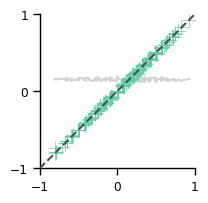

In [9]:
# plot consistency of ratings search
sns.set_context("paper",  font_scale=1)

ssort = ssort.sort_values(by='left')
fig, ax = plt.subplots(figsize=(2,2))

ax.plot(ssort['left'], ssort['chance'], linestyle ='-' , linewidth=1.5,color='lightgray',zorder=1)
ax.scatter(ssort['left'], ssort['right'],  s=100, marker='+', color='mediumaquamarine', zorder=2, linewidths=.5)
ax.plot([-1,1], [-1,1], ls="--", c=".3", linewidth=1.5, zorder=3)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_yticks([-1,0,1,])
ax.set_xticks([-1,0,1,])
#plt.tick_params(left = False, bottom = False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(settings.RESULTS_PATH + '/figure3/3b.svg', dpi=1000)  

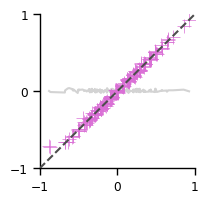

In [10]:
# plot reliability ratings memorize
sns.set_context("paper",  font_scale=1)

msort = msort.sort_values(by='left')
fig, ax = plt.subplots(figsize=(2,2))

ax.plot(msort['left'], msort['chance'], linestyle ='-' , linewidth=1.5,color='lightgray',zorder=1)
ax.scatter(msort['left'], msort['right'],  s=100, marker='+', color='orchid', zorder=2, linewidths=.5)
ax.plot([-1,1], [-1,1], ls="--", c=".3", linewidth=1.5, zorder=3)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_yticks([-1,0,1,])
ax.set_xticks([-1,0,1,])
#plt.tick_params(left = False, bottom = False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(settings.RESULTS_PATH + '/figure3/3d.svg', dpi=1000)  

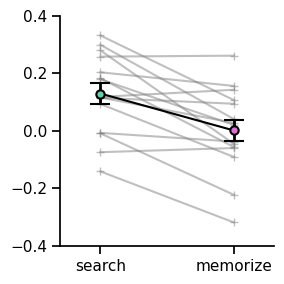

In [12]:
# plot difference between conditions by scene
sns.set_context("notebook",  font_scale=1)

fig, ax = plt.subplots(figsize=(3,3))
grouped = grouped.sort_values(by=['condition', 'image'], ascending=False)
x = [0,.5]
y = [grouped [grouped["condition"]=='search']['score'].mean(),grouped [grouped["condition"]=='memorize']['score'].mean()]
error = [stats.sem(grouped [grouped["condition"]=='search']['score']),stats.sem(grouped [grouped["condition"]=='memorize']['score'])]
for currim in grouped.image.unique():
    currdf = grouped.loc[grouped['image']== currim]
    ax.plot(x, currdf['score'], linestyle="-",marker='+', markersize=6,markeredgewidth=1,  color='gray', 
             markeredgecolor="gray",  alpha=.5,linewidth=1.5,  markerfacecolor='none')
plt.plot([0,.5],[y[0],y[1]],linestyle="-",  color='black' )
plt.errorbar(0, y[0],
             yerr = error[0],  fmt='o', color='mediumaquamarine', 
           markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')
plt.errorbar(.5, y[1],
             yerr = error[1],  fmt='o', color='orchid', 
             markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')

ax.set_xticks([0,.5], labels=['search','memorize'])
ax.set_xlim([-.15, .65])
ax.set_ylim([-.35,.4])
ax.set_yticks([-.4,-.2,0,.2,.4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(settings.RESULTS_PATH + '/figure4/4b.svg',dpi=1000)